In [27]:
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import numpy as np
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import math
import h3

In [28]:
# Load dataset
data = pd.read_csv('../datasets/uber.csv',low_memory=False)
data.drop(columns=['key','id'],inplace=True)
cols = data.columns.tolist()
cols = cols[1:] + cols[:1]
data = data[cols]

In [29]:
print(data.head().style.to_latex())

\begin{tabular}{llrrrrrr}
 & datetime & pick_lon & pick_lat & drop_lon & drop_lat & passenger & fare \\
0 & 2015-05-07 19:52:06 UTC & -73.999817 & 40.738354 & -73.999512 & 40.723217 & 1 & 7.500000 \\
1 & 2009-07-17 20:04:56 UTC & -73.994355 & 40.728225 & -73.994710 & 40.750325 & 1 & 7.700000 \\
2 & 2009-08-24 21:45:00 UTC & -74.005043 & 40.740770 & -73.962565 & 40.772647 & 1 & 12.900000 \\
3 & 2009-06-26 08:22:21 UTC & -73.976124 & 40.790844 & -73.965316 & 40.803349 & 3 & 5.300000 \\
4 & 2014-08-28 17:47:00 UTC & -73.925023 & 40.744085 & -73.973082 & 40.761247 & 5 & 16.000000 \\
\end{tabular}



In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   datetime   200000 non-null  object 
 1   pick_lon   200000 non-null  float64
 2   pick_lat   200000 non-null  float64
 3   drop_lon   199999 non-null  float64
 4   drop_lat   199999 non-null  float64
 5   passenger  200000 non-null  int64  
 6   fare       200000 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 10.7+ MB


Are there any NA values? If so, clean them.

In [31]:
data[data.isna().any(axis=1)]

,datetime,pick_lon,pick_lat,drop_lon,drop_lat,passenger,fare
87946,2013-07-02 03:51:57 UTC,-73.950581,40.779692,NaN,NaN,0,24.1


In [32]:
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199999 entries, 0 to 199999
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   datetime   199999 non-null  object 
 1   pick_lon   199999 non-null  float64
 2   pick_lat   199999 non-null  float64
 3   drop_lon   199999 non-null  float64
 4   drop_lat   199999 non-null  float64
 5   passenger  199999 non-null  int64  
 6   fare       199999 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 12.2+ MB


#### Are there are any other illegal column values?

There should be at least one and not more than six passenger.

In [33]:
zero_passengers = data[(data.passenger < 1) | (data.passenger > 6)]
zero_passengers

,datetime,pick_lon,pick_lat,drop_lon,drop_lat,passenger,fare
333,2011-08-05 07:03:08 UTC,-74.013900,40.707800,-73.992300,40.749300,0,10.1
908,2011-09-06 12:25:19 UTC,-73.981000,40.764600,-73.962900,40.778400,0,11.7
926,2012-03-26 18:11:24 UTC,-73.979978,40.765821,-73.983894,40.766873,0,3.3
2000,2012-04-20 15:07:57 UTC,-73.975285,40.750138,-73.974729,40.783151,0,15.7
3011,2012-01-07 19:19:08 UTC,-73.977900,40.789100,-73.983700,40.773600,0,6.1
...,...,...,...,...,...,...,...
196797,2011-01-17 15:52:26 UTC,-74.000760,40.757637,-74.004852,40.751947,0,3.3
197103,2011-12-10 15:33:12 UTC,0.000000,0.000000,0.000000,0.000000,0,7.3
198872,2011-09-20 19:55:05 UTC,-73.980300,40.742800,-73.967900,40.755600,0,5.7
198902,2011-08-22 21:10:56 UTC,-73.996700,40.737200,-74.008500,40.704000,0,12.1


In [34]:
print('There are {} ride(s) with zero passengers and {} ride(s) with more than six passengers.'.format(len(zero_passengers[zero_passengers.passenger<1]),len(zero_passengers[zero_passengers.passenger>6])))

There are 708 ride(s) with zero passengers and 1 ride(s) with more than six passengers.


In [35]:
data = data[(data.passenger > 0) & (data.passenger <= 6)]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199290 entries, 0 to 199999
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   datetime   199290 non-null  object 
 1   pick_lon   199290 non-null  float64
 2   pick_lat   199290 non-null  float64
 3   drop_lon   199290 non-null  float64
 4   drop_lat   199290 non-null  float64
 5   passenger  199290 non-null  int64  
 6   fare       199290 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 12.2+ MB


<AxesSubplot:>

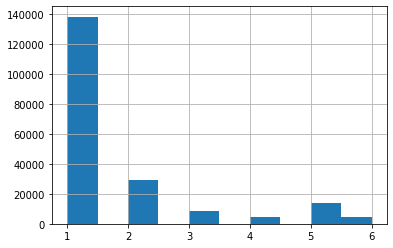

In [36]:
data.passenger.hist()

Scatter plot with illegal coordinates

In [37]:
# df = pd.DataFrame()
# a = np.hstack((data[['pick_lon','pick_lat']],data[['drop_lon','drop_lat']]))
# df[['lon','lat']] = np.array([[aa[0],aa[1]] for aa in a])

# geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
# gdf = GeoDataFrame(df, geometry=geometry)   
# #this is a simple map that goes with geopandas
# world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

Let us first clear the obvious outliers: We need $-180 \leq lon \leq 180$ and $-90 \leq lat \leq 90$

In [38]:
# Clean the data in terms of outlier co-ordinates
data = data[~((data['pick_lon']>180) | (data['pick_lon']<-180) | (data['pick_lat']>90) | (data['pick_lat']<-90))]
data = data[~((data['drop_lon']>180) | (data['drop_lon']<-180) | (data['drop_lat']>90) | (data['drop_lat']<-90))]

array([[<AxesSubplot:title={'center':'pick_lat'}>,
        <AxesSubplot:title={'center':'drop_lat'}>],
       [<AxesSubplot:title={'center':'pick_lon'}>,
        <AxesSubplot:title={'center':'drop_lon'}>]], dtype=object)

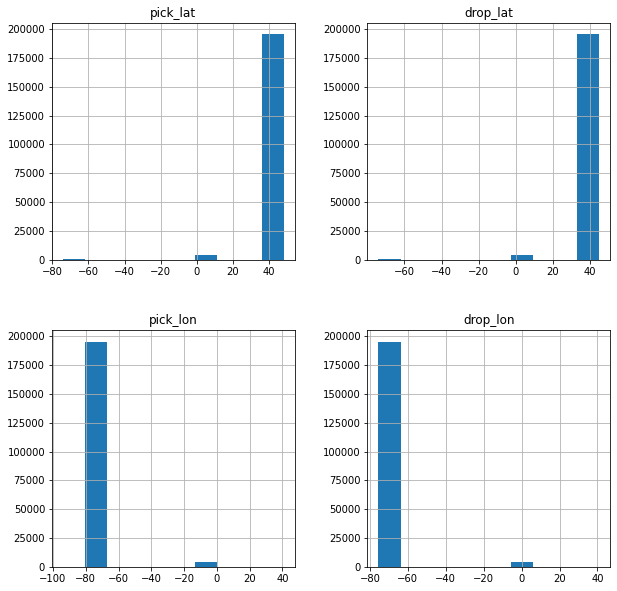

In [39]:
data.hist(["pick_lat","drop_lat","pick_lon","drop_lon"],figsize=(10,10))

Plot with illegal coordinates removed

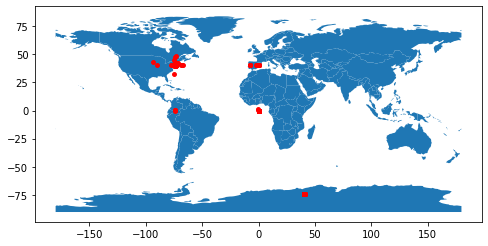

In [40]:
# df = pd.DataFrame()
# a = np.hstack((data[['pick_lon','pick_lat']],data[['drop_lon','drop_lat']]))
# df[['lon','lat']] = np.array([[aa[0],aa[1]] for aa in a])

# geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
# gdf = GeoDataFrame(df, geometry=geometry)   
# #this is a simple map that goes with geopandas
# world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# gdf.plot(ax=world.plot(figsize=(8, 6)), marker='o', color='red', markersize=15);
# plt.savefig('./figs/worldscatter.png',dpi=414,bbox_inches='tight')

Let us only keep the rides from around NYC

In [17]:
# Clean the data in terms of outlier co-ordinates
data = data[~((data['pick_lon']>-72) | (data['pick_lon']<-76) | (data['pick_lat']>42) | (data['pick_lat']<39))]
data = data[~((data['drop_lon']>-72) | (data['drop_lon']<-76) | (data['drop_lat']>42) | (data['drop_lat']<39))]

In [18]:
print('Number of data points removed = {} ({}%)'.format(200000-len(data),(200000-len(data))/2000))

Number of data points removed = 4841 (2.4205%)


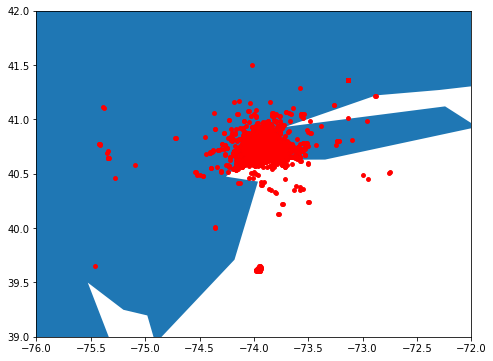

In [26]:
# df = pd.DataFrame()
# a = np.vstack((data[['pick_lon','pick_lat']],data[['drop_lon','drop_lat']]))
# df[['lon','lat']] = np.array([[aa[0],aa[1]] for aa in a])

# geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
# gdf = GeoDataFrame(df, geometry=geometry)   
# #this is a simple map that goes with geopandas
# world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# ax = gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15)
# ax.set_xlim(-76, -72)
# ax.set_ylim(39,42)
# plt.savefig('./figs/nycscatter.png',dpi=414,bbox_inches='tight')

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195159 entries, 0 to 199999
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   datetime   195159 non-null  object 
 1   pick_lon   195159 non-null  float64
 2   pick_lat   195159 non-null  float64
 3   drop_lon   195159 non-null  float64
 4   drop_lat   195159 non-null  float64
 5   passenger  195159 non-null  int64  
 6   fare       195159 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 11.9+ MB


Are there rides with non-positive fares?

In [20]:
data[data.fare<=0]

,datetime,pick_lon,pick_lat,drop_lon,drop_lat,passenger,fare
20744,2015-04-22 23:25:07 UTC,-73.658897,40.805199,-73.658897,40.805199,1,0.00
22182,2010-03-20 02:59:51 UTC,-73.994366,40.755395,-73.998718,40.854853,2,0.00
63395,2015-03-03 23:07:41 UTC,-73.992249,40.748936,-73.988518,40.748180,1,-5.00
71246,2010-02-11 21:47:10 UTC,-73.952725,40.768235,-73.949928,40.772208,2,-3.30
79903,2015-05-01 14:43:02 UTC,-73.982430,40.775024,-73.981750,40.778439,1,-3.50
89322,2010-03-09 08:26:10 UTC,-73.972772,40.785657,-73.972867,40.785500,5,-49.57
92063,2010-03-12 08:49:10 UTC,-73.952740,40.768233,-74.007028,40.707338,3,-23.70
98875,2015-03-20 21:31:14 UTC,-74.000359,40.728729,-74.005699,40.728680,5,-52.00
104080,2010-03-09 20:25:10 UTC,-73.952623,40.766942,-73.953787,40.784882,1,-7.30
139272,2010-02-23 18:52:10 UTC,-73.988727,40.736445,-73.977622,40.750487,1,-6.90


In [21]:
data = data[data.fare>0]

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195140 entries, 0 to 199999
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   datetime   195140 non-null  object 
 1   pick_lon   195140 non-null  float64
 2   pick_lat   195140 non-null  float64
 3   drop_lon   195140 non-null  float64
 4   drop_lat   195140 non-null  float64
 5   passenger  195140 non-null  int64  
 6   fare       195140 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 11.9+ MB


Are there rides that start and end at the same location?

In [23]:
data[(data.pick_lat == data.drop_lat) & (data.pick_lon == data.drop_lon)]

,datetime,pick_lon,pick_lat,drop_lon,drop_lat,passenger,fare
5,2011-02-12 02:27:09 UTC,-73.969019,40.755910,-73.969019,40.755910,1,4.90
48,2013-01-03 22:24:41 UTC,-73.993498,40.764686,-73.993498,40.764686,1,56.80
84,2009-08-07 10:43:07 UTC,-73.975058,40.788820,-73.975058,40.788820,1,49.57
166,2014-01-22 21:01:18 UTC,-73.992937,40.757780,-73.992937,40.757780,1,4.50
361,2009-08-24 17:25:00 UTC,-73.928705,40.753475,-73.928705,40.753475,1,10.10
...,...,...,...,...,...,...,...
199448,2010-07-24 21:16:00 UTC,-73.924907,40.745833,-73.924907,40.745833,3,5.70
199612,2013-02-17 11:27:00 UTC,-73.969717,40.765832,-73.969717,40.765832,3,4.50
199647,2009-06-07 02:07:26 UTC,-73.956623,40.771633,-73.956623,40.771633,1,2.50
199917,2013-06-24 22:17:43 UTC,-73.793768,40.656939,-73.793768,40.656939,1,4.50


In [24]:
data = data[~((data.pick_lat == data.drop_lat) & (data.pick_lon == data.drop_lon))]

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 193102 entries, 0 to 199999
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   datetime   193102 non-null  object 
 1   pick_lon   193102 non-null  float64
 2   pick_lat   193102 non-null  float64
 3   drop_lon   193102 non-null  float64
 4   drop_lat   193102 non-null  float64
 5   passenger  193102 non-null  int64  
 6   fare       193102 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 11.8+ MB


Convert datetime column to datetime format

In [19]:
# Convert the pickup time column to datatime format
data.datetime = pd.to_datetime(data.datetime)
data.datetime = data.datetime.dt.tz_convert('America/New_York')

Add additional columns related to the pick up time such as the year, quarter, month, day of the month, day of the week, hour of the day, isweekday

In [20]:
data [["year","quarter","month","dayofmonth","dayofweek","hour"]] = [[time.year,time.quarter, time.month,time.day,time.dayofweek,time.hour] for time in data.datetime]
data["isweekend"] = (data.dayofweek > 4)
data["large"] = data.passenger > 3
data['expensive'] = data.fare/data.distance/data.passenger > (data.fare/data.distance/data.passenger).mean()
h3_dist = []
for i in range(len(data)):
    h3_dist.append(h3.point_dist((data.pick_lat[i],data.pick_lon[i]),(data.drop_lat[i],data.drop_lon[i]), unit='m'))
data['h3_dist'] = h3_dist

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195159 entries, 0 to 199999
Data columns (total 15 columns):
 #   Column      Non-Null Count   Dtype                           
---  ------      --------------   -----                           
 0   datetime    195159 non-null  datetime64[ns, America/New_York]
 1   pick_lon    195159 non-null  float64                         
 2   pick_lat    195159 non-null  float64                         
 3   drop_lon    195159 non-null  float64                         
 4   drop_lat    195159 non-null  float64                         
 5   passenger   195159 non-null  int64                           
 6   fare        195159 non-null  float64                         
 7   year        195159 non-null  int64                           
 8   quarter     195159 non-null  int64                           
 9   month       195159 non-null  int64                           
 10  dayofmonth  195159 non-null  int64                           
 11  dayofweek   1

Generate graphs around NYC Metro and combine them

In [22]:
# points = [(40.59543190832063, -74.61524708442168),(40.57956607358215, -74.41336306634196),(40.624919921889315, -74.22044605892036),(40.64899412931219, -74.00765704151603),(40.68034128679623, -73.84634378832273),(40.70160462280688, -73.65192816730897),(40.73252493512613, -73.4428071391872),(40.35711055264451, -74.66780888071568),(40.46138146720181, -74.53422996512622),(40.56348711167296, -74.40029946861245),(40.665930235373324, -74.26532148714463),(40.768507830986266, -74.12740119976648),(40.87054657749583, -73.9925979658884),(40.97331093297341, -73.85252244635357),(41.03441830359952, -73.7744854980059),(40.91754179156539, -74.18325534755496),(40.88127696935471, -73.99776106384634),(40.84965594706608, -73.8292762597099),(40.810778709534524, -73.62590350447473),(40.8022279876293, -73.54754914138091)]


# G = {}
# for i,pp in enumerate(points):
#     G[i] = ox.graph_from_point(pp,dist=10000, network_type='drive')
#     G[i] = ox.speed.add_edge_speeds(G[i])
#     G[i] = ox.speed.add_edge_travel_times(G[i])
#     print('Done with {}'.format(i))


# GG = nx.MultiDiGraph()
# for gg in G:
#     GG = nx.compose(GG,G[gg])

# ox.save_graphml(GG, "NYCMetro.graphml")

In [23]:
# Load the NYC Metro graphml file (should take about 45 seconds)
G = ox.load_graphml("NYCMetro.graphml")

In [24]:
# ox.plot_graph(G)

In [25]:
dis_dur = []
pickups = data[["pick_lon","pick_lat"]].values
pickup_nodes = ox.distance.nearest_nodes(G, pickups[:,0], pickups[:,1])
dropoffs = data[["drop_lon","drop_lat"]].values
dropoff_nodes = ox.distance.nearest_nodes(G, dropoffs[:,0], dropoffs[:,1])

In [26]:
# memo = {}

# for i in range(len(pickup_nodes)):
#     if (pickup_nodes[i], dropoff_nodes[i]) in memo:
#         dis_dur.append(memo[(pickup_nodes[i], dropoff_nodes[i])])
#     else:
#         try:
#             memo[(pickup_nodes[i], dropoff_nodes[i])] = [nx.shortest_path_length(G, pickup_nodes[i], dropoff_nodes[i], weight='length'), nx.shortest_path_length(G, pickup_nodes[i], dropoff_nodes[i], weight='travel_time')]
#         except:
#             memo[(pickup_nodes[i], dropoff_nodes[i])] = [-1,-1]
#         dis_dur.append(memo[(pickup_nodes[i], dropoff_nodes[i])])
#     if i % 1000 == 0:
#         print(i)

# data[["distance","duration"]] = dis_dur

# data.to_csv('../datasets/uber_cleaned.csv',index=False)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


In [32]:
data["distance"] = data.distance.round(2)
data["duration"] = data.duration.round(2)

In [42]:
data['pick_nodes'] = pickup_nodes
data['drop_nodes'] = dropoff_nodes

In [72]:
data.to_csv('../datasets/uber_cleaned_old.csv',index=False)

In [44]:
data.pick_nodes[(data.distance == -1) & (data.duration == -1)].value_counts()

42438898      8136
42429918      2824
3276524466    2141
42429980      1848
42442961      1606
              ... 
42923790         1
42866942         1
42459493         1
42825901         1
42769941         1
Name: pick_nodes, Length: 1811, dtype: int64

In [50]:
missing_dist = data[['pick_nodes','drop_nodes']][(data.distance == -1) & (data.duration == -1)].value_counts()

In [57]:
data[(data.pick_nodes == 42438898) & (data.drop_nodes == 4597668039)]

,datetime,pick_lon,pick_lat,drop_lon,drop_lat,passenger,fare,year,quarter,month,dayofmonth,dayofweek,hour,isweekend,large,distance,duration,pick_nodes,drop_nodes
413,2010-11-09 01:56:00-05:00,-73.976657,40.751820,-73.990708,40.750923,1,4.9,2010,4,11,9,1,1,False,False,-1.0,-1.0,42438898,4597668039
1632,2011-11-22 11:25:00-05:00,-73.976727,40.752142,-73.988835,40.752685,6,7.3,2011,4,11,22,1,11,False,True,-1.0,-1.0,42438898,4597668039
1647,2013-07-10 07:44:18-04:00,-73.972754,40.752596,-73.986061,40.754178,1,8.0,2013,3,7,10,2,7,False,False,-1.0,-1.0,42438898,4597668039
1681,2010-12-21 15:39:25-05:00,-73.969615,40.753464,-73.989725,40.751658,1,8.1,2010,4,12,21,1,15,False,False,-1.0,-1.0,42438898,4597668039
2379,2013-03-25 16:16:00-04:00,-73.980937,40.750957,-73.990715,40.750802,1,4.5,2013,1,3,25,0,16,False,False,-1.0,-1.0,42438898,4597668039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197969,2012-08-02 07:10:23-04:00,-73.980577,40.752984,-73.985749,40.747306,1,4.5,2012,3,8,2,3,7,False,False,-1.0,-1.0,42438898,4597668039
198429,2010-01-16 18:56:30-05:00,-73.977164,40.753768,-73.988296,40.743861,1,6.1,2010,1,1,16,5,18,True,False,-1.0,-1.0,42438898,4597668039
198748,2013-05-26 07:17:17-04:00,-73.974905,40.748345,-73.991325,40.750863,1,6.5,2013,2,5,26,6,7,True,False,-1.0,-1.0,42438898,4597668039
199389,2010-01-26 11:29:12-05:00,-73.976403,40.750414,-73.986631,40.745111,1,6.1,2010,1,1,26,1,11,False,False,-1.0,-1.0,42438898,4597668039


In [59]:
G2 = ox.load_graphml('Manhattan.graphml')

In [61]:
nx.shortest_path_length(G2,42438898,4597668039,weight='length')

3157.4269999999997

In [66]:
dict(G.nodes(data=True))[4597668039]

{'y': 40.7389179,
 'x': -73.9873554,
 'highway': 'traffic_signals',
 'street_count': 4}

In [68]:
pickups = data[["pick_lon","pick_lat"]].values
pickup_nodes = ox.distance.nearest_nodes(G, pickups[:,0], pickups[:,1],return_dist =True)
dropoffs = data[["drop_lon","drop_lat"]].values
dropoff_nodes = ox.distance.nearest_nodes(G, dropoffs[:,0], dropoffs[:,1],return_dist =True)

In [71]:
data['pick_node_dist'] = pickup_nodes[1]
data['drop_node_dist'] = dropoff_nodes[1]